# Part 1 - Data Preprocessing

In [1]:
# Importing the Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Importing the training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values


In [3]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [4]:
# Creating a data structure with 60 timsestamps and 1 output
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [5]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Part 2: Building the RNN

In [6]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Importing Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [7]:
# tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6526207504596407552,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3132581479
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12158901564104102951
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [8]:
# Initializing the RNN
regressor = Sequential()

In [9]:
# Adding first LSTM layer with 50 mermory cells
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% dropout
regressor.add(Dropout(0.2))

In [10]:
# Adding 2nd LSTM layer with 50 mermory cells
regressor.add(LSTM(units = 50, return_sequences = True))
# 20% dropout
regressor.add(Dropout(0.2))

In [11]:
# Adding 3rd LSTM layer with 50 mermory cells
regressor.add(LSTM(units = 50, return_sequences = True))
# 20% dropout
regressor.add(Dropout(0.2))

In [12]:
# Adding 4th LSTM layer with 50 mermory cells
regressor.add(LSTM(units = 50))
# 20% dropout
regressor.add(Dropout(0.2))

In [13]:
# Adding the output layer
regressor.add(Dense(units = 1))

In [14]:
# Compiling the rnn model
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [16]:
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 [==============================] - 11s 35ms/step - loss: 0.1204
Epoch 2/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0068
Epoch 3/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0065
Epoch 4/100
38/38 [==============================] - 1s 36ms/step - loss: 0.0054
Epoch 5/100
38/38 [==============================] - 1s 37ms/step - loss: 0.0049
Epoch 6/100
38/38 [==============================] - 2s 42ms/step - loss: 0.0048
Epoch 7/100
38/38 [==============================] - 1s 39ms/step - loss: 0.0050
Epoch 8/100
38/38 [==============================] - 1s 36ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0048
Epoch 10/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0050
Epoch 11/100
38/38 [==============================] - 1s 36ms/step - loss: 0.0040
Epoch 12/100
38/38 [==============================] - 1s 35ms/step - loss: 0.0049
Epoch 13/100
38/38 [====

In [17]:
regressor.save('model')

INFO:tensorflow:Assets written to: model\assets
INFO:tensorflow:Assets written to: model\assets


# Part 3 Making the prediction and visiualizing the steps

# Predicting the Stock Price of 2017

In [18]:
# Loading the test variables
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [19]:
# Preparing the dataset for predicting the january stock prices
# We need 60 timesteps before the first january stock price
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60 : ].values
inputs = inputs.reshape(-1, 1) # For making (80,) -> (80,1)

# Scaling the input
inputs = sc.transform(inputs)

In [20]:
# Creating a data structure with 60 timsestamps and 1 output
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [21]:
# Predict the stock price of january 2017
predicted_stock_price = regressor.predict(X_test)

In [22]:
# inversing the scaling
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

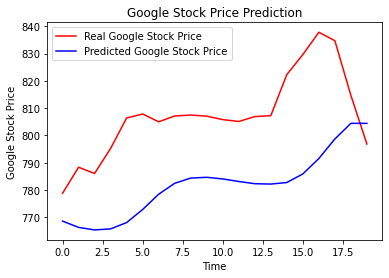

In [23]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()